<a href="https://colab.research.google.com/github/LeonardoGoncRibeiro/06_MachineLearning/blob/main/01_Basic/07_OptimizingModelHyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning: Optimizing model hyperparameters

When dealing with Machine Learning models, we often have to define model hyperparameters beforehand. These are very important for model performance but, at the same time, they are not always easy to set. Thus, we can try to optimize the model hyperparameters in order to find the optimal set of parameters that improve our model accuracy. 

In this course we will use the following packages:

In [34]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import export_graphviz
import graphviz

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score

Also, we will use the following dataset, which contains information about car prices, their age, their km per year, and whether they were sold or not.

In [2]:
uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

df = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
df.columns = ['Price', 'Sold', 'Age', 'Km_per_year']

df.head()

,Price,Sold,Age,Km_per_year
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


## Fitting some baseline models to our data

So, first, let's start by getting the accuracy of a dummy classifier. For that end, we will use a pipeline:

In [3]:
# Separating target and explicative features
y = df.Sold
X = df.drop('Sold', axis = 1)

# Defining normalization method
scaler = StandardScaler( )

# Defining an estimator
dummy_clf = DummyClassifier( )

# Defining pipeline for production
pipe = Pipeline([('scaler', scaler), ('estimator', dummy_clf)])

# Defining the cross-validation technique
cv = StratifiedKFold(n_splits = 10, shuffle = True)

# Performing the cross-validation
results = cross_validate(pipe, X, y, cv = cv)

# Obtaining the results for cross-validation
acc_avg = results['test_score'].mean( )*100

print("Accuracy: {:.2f}%".format(acc_avg))

Accuracy: 58.00%


Here, we got the accuracy for a dummy classifier, which was 58%. Now, let's run a more robust model, and check if it improves over the dummy classifier. Before doing that, let's create a user-defined function:

In [4]:
def PerformCrossValidation(scaler, model, X, y):
  # Defining pipeline for production
  pipe = Pipeline([('scaler', scaler), ('estimator', model)])

  # Defining the cross-validation technique
  cv = StratifiedKFold(n_splits = 10, shuffle = True)

  # Performing the cross-validation
  results = cross_validate(pipe, X, y, cv = cv)

  # Obtaining the results for cross-validation
  acc_avg = results['test_score'].mean( )*100

  return acc_avg

Now, let's get the accuracy of the decision tree classifier:

In [5]:
dec_tree = DecisionTreeClassifier(max_depth = 2)

acc_avg = PerformCrossValidation(scaler, dec_tree, X, y)

print("Accuracy: {:.2f}%".format(acc_avg))

Accuracy: 75.78%


Nice! Our decision tree classifier showed a much higher accuracy. However, note that, here, we arbitrarily chose the maximum depth for the model: ```max_depth = 2```. What would happen if we try to change this parameter?

# Understanding the max_depth parameter

First, let's understand what is the parameter ```max_depth```. When we use tree-based algorithms (such as a decision tree), our decision tree starts growing, generating new leaves. The parameter ```max_depth``` sets the maximum depth the tree may have. To have a better understanding of this procedure, let's visualize a tree fitted using ```max_depth = 2```:

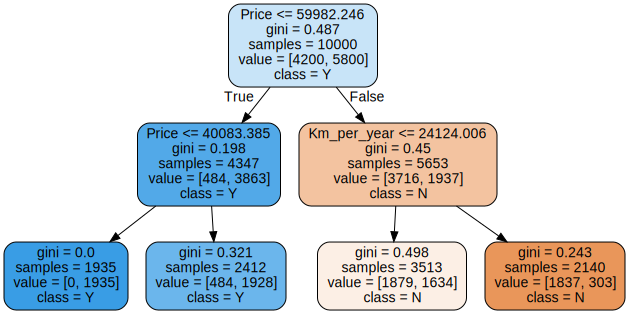

In [6]:
dec_tree = DecisionTreeClassifier(max_depth = 2)
dec_tree.fit(X, y)

dot_data = export_graphviz(dec_tree, out_file = None,
                           filled = True, rounded = True, class_names = ["N", "Y"],
                           feature_names = X.columns)

graphviz.Source(dot_data)

So, here, the maximum depth is 2. Now, let's try to use ```max_depth = 3```.

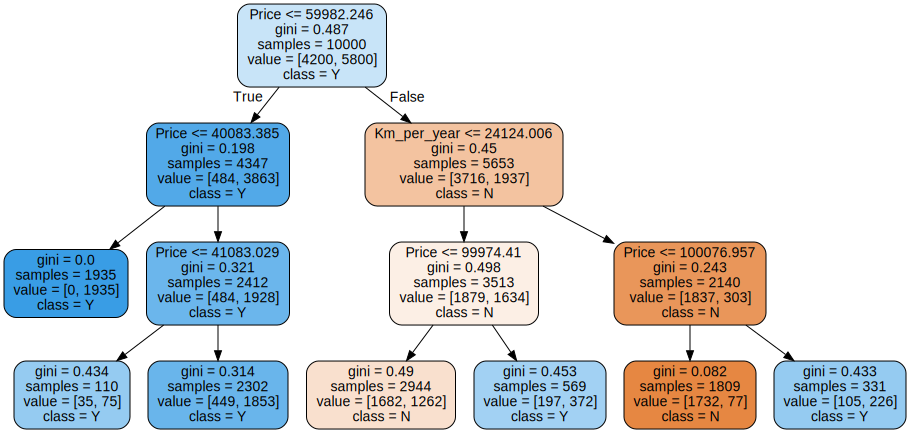

In [7]:
dec_tree = DecisionTreeClassifier(max_depth = 3)
dec_tree.fit(X, y)

dot_data = export_graphviz(dec_tree, out_file = None,
                           filled = True, rounded = True, class_names = ["N", "Y"],
                           feature_names = X.columns)

graphviz.Source(dot_data)

Now, note that we have a much more complex tree. However, this does not mean that we have a better tree (which has a better accuracy in real world data).

## Checking the accuracy for different values of max_depth

Thus, let's check the accuracy for different values of the parameter. First, once again, let's evaluate the average accuracy for ```max_depth = 2```:

In [8]:
dec_tree = DecisionTreeClassifier(max_depth = 2)

acc_avg = PerformCrossValidation(scaler, dec_tree, X, y)

print("Accuracy: {:.2f}%".format(acc_avg))

Accuracy: 75.76%


Our accuracy is 75.78%. Now, let's use ```max_depth = 3```:

In [9]:
dec_tree = DecisionTreeClassifier(max_depth = 3)

acc_avg = PerformCrossValidation(scaler, dec_tree, X, y)

print("Accuracy: {:.2f}%".format(acc_avg))

Accuracy: 78.68%


Our accuracy increased! Nice. However, this does not mean that, everytime we increase the ```max_depth```, we will get a higher accuracy. For instance, for ```max_depth = 10```:

In [10]:
dec_tree = DecisionTreeClassifier(max_depth = 10)

acc_avg = PerformCrossValidation(scaler, dec_tree, X, y)

print("Accuracy: {:.2f}%".format(acc_avg))

Accuracy: 76.57%


Our accuracy was lower. This shows how a more complex model is not always a better model (in terms of accuracy), and why optimizing models is not a trivial task. In the rest of the course, we will see how can we choose the parameter which optimizes the model for our dataset.

## Checking the accuracy of multiple trees

Now, let's try something more: we will fit multiple decision trees, with different ```max_depth```, and plot their accuracies in a graph. This way, we have a simple way of finding which value is the optimal for the parameter. Thus, we can do:

In [11]:
max_depth_list = []
accuracy_list  = []

for md in range(1, 33):
  dec_tree = DecisionTreeClassifier(max_depth = md)
  acc_avg = PerformCrossValidation(scaler, dec_tree, X, y)

  max_depth_list.append(md)
  accuracy_list.append(acc_avg)

Now, we can plot our accuracy using:

Text(0, 0.5, 'Accuracy (%)')

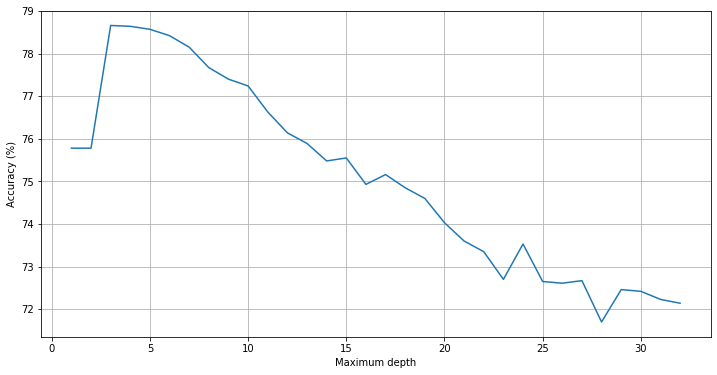

In [12]:
plt.figure(figsize = (12, 6))
plt.plot(max_depth_list, accuracy_list)
plt.grid( )
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy (%)')

We can see that, indeed, the highest accuracy is found for very small values of ```max_depth```. But why?

When we increase ```max_depth```, we are giving more **freedom** to our model. First, it becomes harder and more costly to fit it. But also, the model becomes better fitted to the training set. Actually, the model becomes **overfitted** to the training set. This means that the model will be very good to predict values from the training set, but it may not be as good to predict values from a test or validation sets. 

For instance, let's try to plot the accuracy of the training set. First, let's redefine our user-defined function:

In [13]:
def PerformCrossValidation(scaler, model, X, y):
  # Defining pipeline for production
  pipe = Pipeline([('scaler', scaler), ('estimator', model)])

  # Defining the cross-validation technique
  cv = StratifiedKFold(n_splits = 10, shuffle = True)

  # Performing the cross-validation
  results = cross_validate(pipe, X, y, cv = cv, return_train_score=True)

  # Obtaining the results for cross-validation
  acc_avg_train = results['train_score'].mean( )*100
  acc_avg_test  = results['test_score'].mean( )*100

  return (acc_avg_train, acc_avg_test)

Now, we can do:

In [14]:
max_depth_list = []
train_acc_list = []
test_acc_list  = []

for md in range(1, 33):
  dec_tree = DecisionTreeClassifier(max_depth = md)
  acc_avg_train, acc_avg_test = PerformCrossValidation(scaler, dec_tree, X, y)

  max_depth_list.append(md)
  train_acc_list.append(acc_avg_train)
  test_acc_list.append(acc_avg_test)

Now, to plot our accuracy:

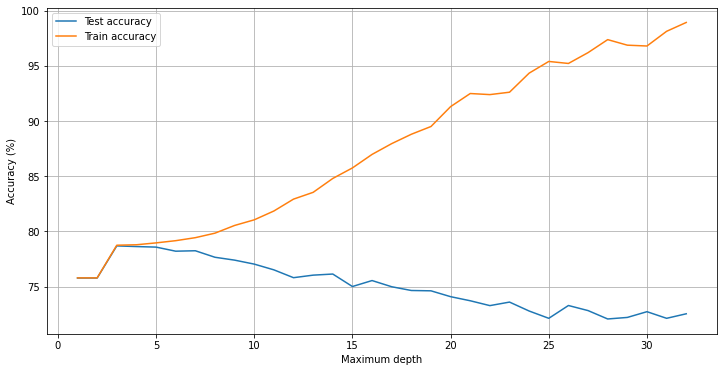

In [15]:
plt.figure(figsize = (12, 6))
plt.plot(max_depth_list, test_acc_list, label = 'Test accuracy')
plt.plot(max_depth_list, train_acc_list, label = 'Train accuracy')
plt.grid( )
plt.xlabel('Maximum depth')
plt.ylabel('Accuracy (%)')
plt.legend( )

Note that, for a very small maximum depth, the train and test accuracy are very similar. However, as we increase the maximum depth, our train accuracy continues to grow, while the test accuracy starts to decrease. That is a very good example of overfitting, where the model represents the train set very well, but is not able to get a good accuracy over the test set.

# Optimizing two hyper-parameters at once

Until now, we evaluated the accuracy for different values of the ```max_depth``` parameter. However, a decision tree has multiple parameters, and one should be able to set the optimal (or almost optimal) values for most of these parameters. For instance, we have the minimum number of samples on a leaf (```min_samples_leaf```).

To analyze both parameters, we should define a grid, where we test all possible combinations of each parameter. Note that, if we have 32 possible values for each parameter, we have 1024 possibilities. Here, it becomes more clear how the optimization of hyper-parameters starts to become more and more expensive as we increase the number of dimensions. Thus, instead of exploring the entire space, we may want to pick some discrete values to test with.

So, let's work with two parameters:

In [16]:
max_depth_list = []
min_leaf_list  = []
train_acc_list = []
test_acc_list  = []

for md in [3, 6, 9, 12, 15, 18, 21, 24]:                                              # Possible values for max_depth
  for msl in [32, 64, 128, 256, 512, 1024]:                                           # Possible values for min_samples_leaf
    dec_tree = DecisionTreeClassifier(max_depth = md, min_samples_leaf = msl)
    acc_avg_train, acc_avg_test = PerformCrossValidation(scaler, dec_tree, X, y)

    max_depth_list.append(md)
    min_leaf_list.append(msl)
    train_acc_list.append(acc_avg_train)
    test_acc_list.append(acc_avg_test)

result = {'Max_depth' : max_depth_list, 
          'Min_samp_leaf' : min_leaf_list, 
          'Train_acc' : train_acc_list, 
          'Test_acc' : test_acc_list}

result_df = pd.DataFrame(result)

This time, we ended up creating a dataframe with our results. To get the best results (based on the test set), we can do:

In [17]:
result_df.sort_values('Test_acc', ascending = False).head( )

,Max_depth,Min_samp_leaf,Train_acc,Test_acc
0,3,32,78.750000,78.70
2,3,128,78.751111,78.69
3,3,256,78.751111,78.69
1,3,64,78.752222,78.68
33,18,256,78.876667,78.40


So, the highest test accuracy is found with ```max_depth = 3```. Also, note that multiple ```min_samples_leaf``` values were able to find a very similar accuracy! The parameter seems to be unimportant for this maximum depth.

## Visualizing the parameter grid

When we had only one parameter, we had a very nice way of visualizing the change in accuracy for a change in the parameter. When we have two parameters, we can also visualize the change in accuracy, but now using a grid.

First, we can try to get the correlation for our dataframe:

In [18]:
pd.options.display.float_format = '{:,.6f}'.format

In [19]:
result_df.corr( )

,Max_depth,Min_samp_leaf,Train_acc,Test_acc
Max_depth,1.000000,0.000000,0.167164,-0.240826
Min_samp_leaf,0.000000,1.000000,-0.934610,-0.730237
Train_acc,0.167164,-0.934610,1.000000,0.504437
Test_acc,-0.240826,-0.730237,0.504437,1.000000


The correlation can tell us how the accuracy is correlated with the parameters. For instance, the correlation between the test accuracy and ```min_samples_leaf``` is very low. That means that, ass ```min_samples_leaf``` increases, the test accuracy tends to decrease.

To visualize the correlation we can use:

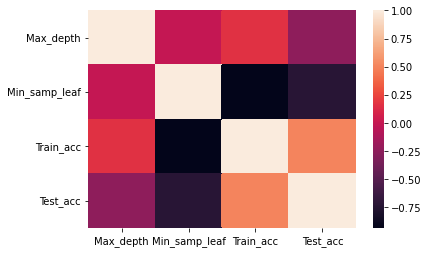

In [20]:
sns.heatmap(result_df.corr( ))

Another way of visualizing how some features are correlated is to use a pairplot:

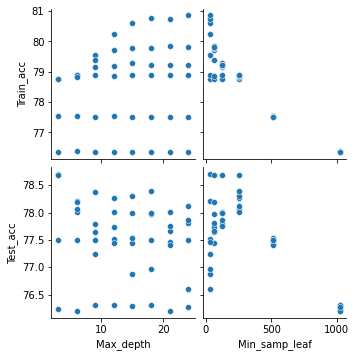

In [21]:
sns.pairplot(result_df, y_vars = ['Train_acc', 'Test_acc'], x_vars = ['Max_depth', 'Min_samp_leaf'])

Here, it is clear that, as ```min_samp_leaf``` increases, the accuracy (both test and train) tends to decrease. Also, as the depth increases, the training accuracy tends to increase. However, this is not always true, as ```min_samples_leaf``` seems to have a strong effect in the accuracy. 

# Exploring more parameters

Finally, the Decision Tree Classifier has more than 2 parameters. In fact, it has a very high number of parameters, and trying to set those by exploring the entire design space and by analyzing and visualizing each effect is not feasible. 

Let's try to define some possible values for another parameter:

In [22]:
possible_max_depth = [2, 4, 6, 8, 10]
possible_min_samples_leaf = [32, 64, 128, 256, 512, 1024]
possible_min_samples_split = [16, 32, 64, 128, 256]

Now, let's, once again, get the test and train accuracy for each set of parameters:

In [23]:
max_depth_list = []
min_leaf_list  = []
min_split_list = []
train_acc_list = []
test_acc_list  = []

for md in possible_max_depth:                                                     # Possible values for max_depth
  for msl in possible_min_samples_leaf:                                           # Possible values for min_samples_leaf
    for mss in possible_min_samples_split:                                        # Possible values for min_samples_split
      dec_tree = DecisionTreeClassifier(max_depth = md, min_samples_leaf = msl)
      acc_avg_train, acc_avg_test = PerformCrossValidation(scaler, dec_tree, X, y)

      max_depth_list.append(md)
      min_leaf_list.append(msl)
      min_split_list.append(mss)
      train_acc_list.append(acc_avg_train)
      test_acc_list.append(acc_avg_test)

result = {'Max_depth' : max_depth_list, 
          'Min_samp_leaf' : min_leaf_list, 
          'Min_samp_split' : min_split_list,
          'Train_acc' : train_acc_list, 
          'Test_acc' : test_acc_list}

result_df = pd.DataFrame(result)

Finally, let's get the set of parameters which returned the highest test accuracy:

In [24]:
result_df.sort_values('Test_acc', ascending = False).head( )

,Max_depth,Min_samp_leaf,Min_samp_split,Train_acc,Test_acc
31,4,32,32,78.750000,78.710000
41,4,128,32,78.750000,78.710000
48,4,256,128,78.751111,78.710000
35,4,64,16,78.750000,78.710000
45,4,256,16,78.751111,78.700000


Nice! However, note that, as we increase the number of parameters, we increase the number of models we are fitting and, thus, we increase the time required to get our optimal parameters. Thus, as we increase the number of parameters, we have to be very careful with the time we spend performing this process.

# Using GridSearchCV

Until now, we showed how to optimize our model for one, two, or three parameters. Using a similar idea, we can optimize our model for $n$ parameters. However, we can also simply use an already implemented method: GridSearchCV. Let's test it. First, let's define the space in which our parameters will be tested:

In [25]:
parameter_space = {'max_depth' : [3, 5, 7],
                   'min_samples_split' : [32, 64, 128],
                   'min_samples_leaf' : [32, 64, 128],
                   'criterion' : ['gini', 'entropy'],
                   'splitter' : ['best', 'random']}

Here, we will test 5 different parameters. On total, we have 108 possibilities. Thus, let's use our GridSearchCV:

In [26]:
SEED = 301
np.random.seed(SEED)

model = DecisionTreeClassifier( )
cv = StratifiedKFold(n_splits = 10, shuffle = True)

grid_search = GridSearchCV(model, parameter_space, cv = cv, return_train_score = True)
grid_search.fit(X, y)
results_df = pd.DataFrame(grid_search.cv_results_)

Nice! Note that, here, we are performing a grid search over our entire parameter space. Now, to see the results, we may simply do:

In [27]:
results_df.head( )

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_splitter,params,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.012558,0.001659,0.002608,0.000218,gini,3,32,32,best,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",...,0.786111,0.787778,0.785444,0.787778,0.787778,0.789000,0.785778,0.788556,0.787511,0.001366
1,0.004447,0.000254,0.002128,0.000403,gini,3,32,32,random,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",...,0.611556,0.722889,0.696111,0.655000,0.649111,0.624444,0.700222,0.679222,0.680289,0.042771
2,0.012076,0.000427,0.002525,0.000067,gini,3,32,64,best,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",...,0.786111,0.787778,0.785444,0.787778,0.787778,0.789000,0.785778,0.788556,0.787511,0.001366
3,0.005621,0.001469,0.002291,0.000395,gini,3,32,64,random,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",...,0.748778,0.686667,0.580000,0.637444,0.742667,0.733889,0.665333,0.711667,0.687689,0.052368
4,0.012192,0.000604,0.002584,0.000294,gini,3,32,128,best,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",...,0.786111,0.787778,0.785444,0.787778,0.787778,0.789000,0.785778,0.788556,0.787511,0.001366


Note that, here, we have a lot of information. To better understand the columns of this dataframe, we can do:

In [28]:
results_df.info( )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean_fit_time            108 non-null    float64
 1   std_fit_time             108 non-null    float64
 2   mean_score_time          108 non-null    float64
 3   std_score_time           108 non-null    float64
 4   param_criterion          108 non-null    object 
 5   param_max_depth          108 non-null    object 
 6   param_min_samples_leaf   108 non-null    object 
 7   param_min_samples_split  108 non-null    object 
 8   param_splitter           108 non-null    object 
 9   params                   108 non-null    object 
 10  split0_test_score        108 non-null    float64
 11  split1_test_score        108 non-null    float64
 12  split2_test_score        108 non-null    float64
 13  split3_test_score        108 non-null    float64
 14  split4_test_score        1

So, let's print only the most important columns:

In [29]:
results_df_summary = results_df[['params', 'mean_train_score', 'mean_test_score', 'mean_fit_time']].copy( )

results_df_summary.sort_values('mean_test_score', ascending = False)

,params,mean_train_score,mean_test_score,mean_fit_time
0,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.787511,0.786900,0.012558
12,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.787511,0.786900,0.012536
70,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.787511,0.786900,0.016280
68,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.787511,0.786900,0.016774
66,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.787511,0.786900,0.017167
...,...,...,...,...
3,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.687689,0.682800,0.005621
1,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.680289,0.679200,0.004447
5,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.681889,0.678300,0.004996
71,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.679722,0.676100,0.004326


Nice! So, our best performing model showed an average test score of 78.69%. Also, this is very close to the average train score, which means that the model is, likely, not overfitted to the training data.

If we simply want to get the best parameters, we may do:

In [30]:
grid_search.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 32,
 'min_samples_split': 32,
 'splitter': 'best'}

Also, we may get the best trained model from:

In [31]:
best_model = grid_search.best_estimator_

In [32]:
best_model

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

Nice! So, let's test this model in the entire dataset:

In [33]:
y_pred = best_model.predict(X)

acc = accuracy_score(y, y_pred)*100

print("Accuracy: {:.2f}%".format(acc))

Accuracy: 78.75%


Nice! Our accuracy was very close to the accuracy found in the cross-validation.

# Nested cross-validation

Note that, however, when we get the accuracy of the best model using a predict method, we are being very optimistic about the accuracy of our model. That happens because we have already fitted and picked our best model for $X$, and using $X$ again to check its accuracy will certainly return a high value. 

Nested CV effectively uses a series of train/validation/test splits to run away from this issue. Here:

* One set is used to train the model.
* One set is used to evaluate the accuracy and pick the hyper-parameters.
* One set is used to estimate the accuracy (and, therefore, the generalization error).

Thus, after we perform a GridSearchCV, what we should do is perform a new cross-validation. We can do that using:

In [48]:
scores = cross_val_score(grid_search, X, y, cv = cv)

Finally, we can evaluate the average accuracy (and the confidence interval) by:

In [49]:
acc_avg = scores.mean( )*100
acc_std = scores.std( )*100

print("Accuracy: {:.2f}% - Confidence interval [{:.2f}%, {:.2f}%]".format(acc_avg, acc_avg - 2*acc_std, acc_avg + 2*acc_std))

Accuracy: 78.68% - Confidence interval [76.77%, 80.59%]


Nice! Note that the accuracy we evaluated previously was very close to the accuracy from nested cross-validation. 

To end things up, let's plot our best decision tree:

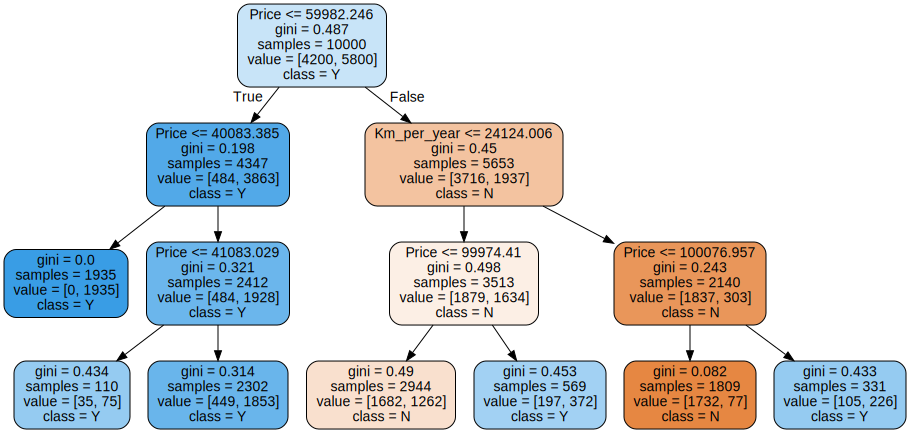

In [50]:
dot_data = export_graphviz(best_model, out_file = None,
                           filled = True, rounded = True, class_names = ["N", "Y"],
                           feature_names = X.columns)

graphviz.Source(dot_data)